In [1]:
import os
from sklearn.preprocessing import LabelBinarizer
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

2023-09-24 22:04:40.279397: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
folder = "Downloads/weather"
#directory with images folder

In [3]:
images = []
labels = []

# image size
image_size = (224, 224)



In [4]:
# scan folder
for x in os.listdir(folder):
    image_path = os.path.join(folder, x)
    pic = cv2.imread(image_path)
    if pic is not None: # check if image is loaded
       
        if x.startswith("rain"):# creation of labels based on image classifications
            label = "rain"
        elif x.startswith("cloudy"):
            label = "cloudy"
        elif x.startswith("shine"):
            label = "shine"
        elif x.startswith("sunrise"):
            label = "sunrise"
        else:
            label = "other" 
            
       
        pic = cv2.resize(pic, image_size) # adjust size
        
        images.append(pic)
        labels.append(label)

In [5]:
# Verify unique labels
unique_labels = np.unique(labels)

print(unique_labels)

['cloudy' 'rain' 'shine' 'sunrise']


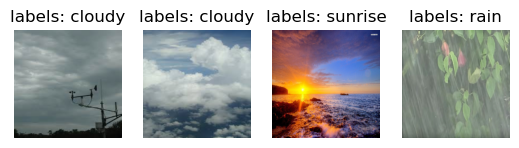

In [6]:
num_images = min(4, len(images)) # check images are loaded

s_four = np.random.choice(len(images), num_images, replace=False) # Extract 4 images randomly

# plot 
for i, idx in enumerate(s_four):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))  
    plt.title(f"labels: {labels[idx]}")
    plt.axis('off')

plt.show()

In [7]:
label_counts = {"rain": 0, "cloudy": 0, "shine": 0, "sunrise": 0, "other": 0}

In [8]:
for label in labels: # count num images per category
    label_counts[label] += 1

for label, count in label_counts.items():
    print(f"{label}: {count}")

rain: 214
cloudy: 300
shine: 252
sunrise: 357
other: 0


In [9]:
label_binarizer = LabelBinarizer()

one_hot_labels = label_binarizer.fit_transform(labels) # one-hot encoding for labels


In [10]:
type(images)

list

In [11]:
# normalize pixel 

images = np.array(images)
images = images.astype(np.float32)# data must be an array float32

images /= 255.0
# check data is in interval 0 and 1
print(np.min(images))
print(np.max(images))


0.0
1.0


In [25]:
#split dataset train and test
from sklearn.model_selection import train_test_split

X_train_test, X_val, y_train_test, y_val = train_test_split(images, one_hot_labels, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=0.25, random_state=42)



In [19]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))# load pre-trained model VGG16

In [20]:
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)  # 4 categories: cloudy, rain, shine, sunrise

In [21]:
model = Model(inputs=base_model.input, outputs=x) # final model

In [22]:
# freeze weights
for layer in base_model.layers:
    layer.trainable = False

In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
cnn_fit = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
22/22 [==============================] - 119s 5s/step - loss: 1.0283 - accuracy: 0.5958 - val_loss: 0.4484 - val_accuracy: 0.8578
Epoch 2/10
22/22 [==============================] - 114s 5s/step - loss: 0.4426 - accuracy: 0.8395 - val_loss: 0.3392 - val_accuracy: 0.9022
Epoch 3/10
22/22 [==============================] - 111s 5s/step - loss: 0.3347 - accuracy: 0.8767 - val_loss: 0.3263 - val_accuracy: 0.9022
Epoch 4/10
22/22 [==============================] - 109s 5s/step - loss: 0.2631 - accuracy: 0.9094 - val_loss: 0.2818 - val_accuracy: 0.9200
Epoch 5/10
22/22 [==============================] - 111s 5s/step - loss: 0.1961 - accuracy: 0.9435 - val_loss: 0.2468 - val_accuracy: 0.9200
Epoch 6/10
22/22 [==============================] - 110s 5s/step - loss: 0.1342 - accuracy: 0.9599 - val_loss: 0.2277 - val_accuracy: 0.9422
Epoch 7/10
22/22 [==============================] - 117s 5s/step - loss: 0.1789 - accuracy: 0.9435 - val_loss: 0.2584 - val_accuracy: 0.9200
Epoch 8/10
22

In [27]:
# Model evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test)

8/8 [==============================] - 27s 3s/step - loss: 0.1965 - accuracy: 0.9378
